<a href="https://colab.research.google.com/github/NajlaZuhir/Financial-Distress-Predictor/blob/main/V1_MLZoomCamp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Classification** of **financially distressed** companies using the **CRISP-DM** framework, addressing challenges of class imbalance*

#### 1) **Business Understanding**

The **goal** of this project was to **identify financially distressed companies** — those struggling to pay employees, bills, or meet other financial obligations.

From a **business perspective, detecting distressed companies early is critical**, while misclassifying healthy companies as distressed carries a much lower cost. This makes the problem cost-sensitive, where minimizing false negatives (missed distressed firms) is the top priority.

#### 2) **Data Collection & Understanding**

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
df = pd.read_csv('Financial Distress.csv') # Kaggle  dataset
df.head() #  Dataset Overview

,Company,Time,Financial Distress,x1,x2,x3,x4,x5,x6,x7,...,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
0,1,1,0.010636,1.2810,0.022934,0.87454,1.21640,0.060940,0.188270,0.52510,...,85.437,27.07,26.102,16.000,16.0,0.2,22,0.060390,30,49
1,1,2,-0.455970,1.2700,0.006454,0.82067,1.00490,-0.014080,0.181040,0.62288,...,107.090,31.31,30.194,17.000,16.0,0.4,22,0.010636,31,50
2,1,3,-0.325390,1.0529,-0.059379,0.92242,0.72926,0.020476,0.044865,0.43292,...,120.870,36.07,35.273,17.000,15.0,-0.2,22,-0.455970,32,51
3,1,4,-0.566570,1.1131,-0.015229,0.85888,0.80974,0.076037,0.091033,0.67546,...,54.806,39.80,38.377,17.167,16.0,5.6,22,-0.325390,33,52
4,2,1,1.357300,1.0623,0.107020,0.81460,0.83593,0.199960,0.047800,0.74200,...,85.437,27.07,26.102,16.000,16.0,0.2,29,1.251000,7,27


In [40]:
print(df.shape)
print((df.isnull().sum() > 0).any()) # Check if any column has missing Values

(3672, 86)
False


In [41]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(include='object').columns.tolist()

print(f"Number of numerical variables: {len(numerical_cols)}")
print(f"Number of categorical variables: {len(categorical_cols)}")


Number of numerical variables: 86
Number of categorical variables: 0


**Summary:**
the Goal was to know the data deeply using pandas and numpy
- Dataset size (3672, 86).
- All columns are numerical with no missing values.
- The dataset is highly imbalanced, with Class 0 being the majority class and Class 1 being the minority class.

There is many more occurencies of healthy companies than the ones under financial distress.

#### 3) **Exploratory Data Analysis**

**Feature Importance Analysis & Selection**

1) Checking for **leakage features**: to drop columns that directly encode the target

In [42]:
# Correlation of all features with the target
corr_with_target = (
    df.corr()['Financial Distress']
    .drop('Financial Distress')
    .sort_values(ascending=False)
)

abs_corr = corr_with_target.abs().sort_values(ascending=False)

# high correlations
potential_leakage = abs_corr[abs_corr > 0.9]

len(potential_leakage)

0

2) Checking for **highly correlated features** with each other, keeping only one representative feature to:

- Reduce multicollinearity

- Improve model stability

- Simplify interpretation

In [43]:
threshold = 0.85

X = df.drop('Financial Distress', axis=1)

corr_matrix = X.corr().abs()

upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

to_drop = [
    column for column in upper_triangle.columns
    if any(upper_triangle[column] > threshold)
]

df_reduced_1 = df.drop(columns=to_drop)
print(f"Number of features before filtering: {X.shape[1]}")
print(f"Number of features to drop: {len(to_drop)}")
print(f"Number of features after filtering: {df_reduced_1.shape[1]}")

Number of features before filtering: 85
Number of features to drop: 23
Number of features after filtering: 63


3. Checking for **Feature-Target Correlation Filtering:** Keep only features that have a meaningful correlation with the target.

In [44]:
# Compute correlation of all features with the target
cor_target = df_reduced_1.corr()['Financial Distress'].abs()

# Set a threshold, e.g., remove features with correlation < 0.05
irrelevant_features = cor_target[cor_target < 0.05].index.tolist()

# Reduced dataset
df_reduced_2 = df_reduced_1.drop(columns=irrelevant_features)
print(f"Features reduced from {df_reduced_1.shape[1]-1} to {len(irrelevant_features)}")


Features reduced from 62 to 31


4. **Binarize** target variable, check for **inbalance distribution** & **model-based feature importance** using a Random Forest

In [45]:
# binarize

def isDistressed(x):
    """
    Returns 1 if x is less than -0.5, 0 otherwise.
    1 means Financially Distressed, 0 means Financially Healthy.
    """
    if x < -0.5:
        return 1
    elif x >= -0.5:
        return 0

df_reduced_2["Financial Distress"] = df_reduced_2["Financial Distress"].apply(isDistressed)

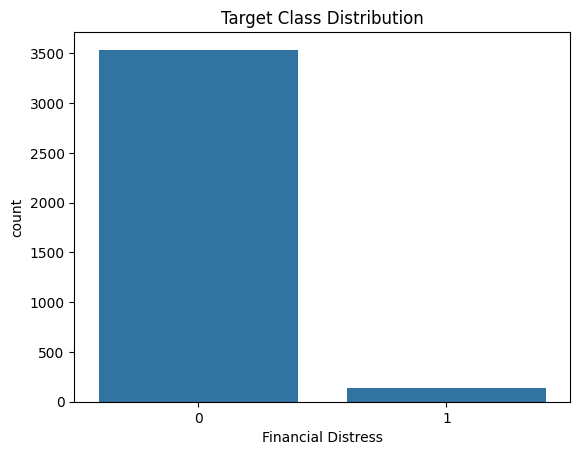

In [46]:
sns.countplot(x='Financial Distress', data=df_reduced_2)
plt.title('Target Class Distribution')
plt.show()



In [47]:
# Analyze Class Imbalance
print(df_reduced_2['Financial Distress'].value_counts())

print("\nClass percentage:")
print(df_reduced_2['Financial Distress'].value_counts(normalize=True) * 100)

Financial Distress
0    3536
1     136
Name: count, dtype: int64

Class percentage:
Financial Distress
0    96.296296
1     3.703704
Name: proportion, dtype: float64


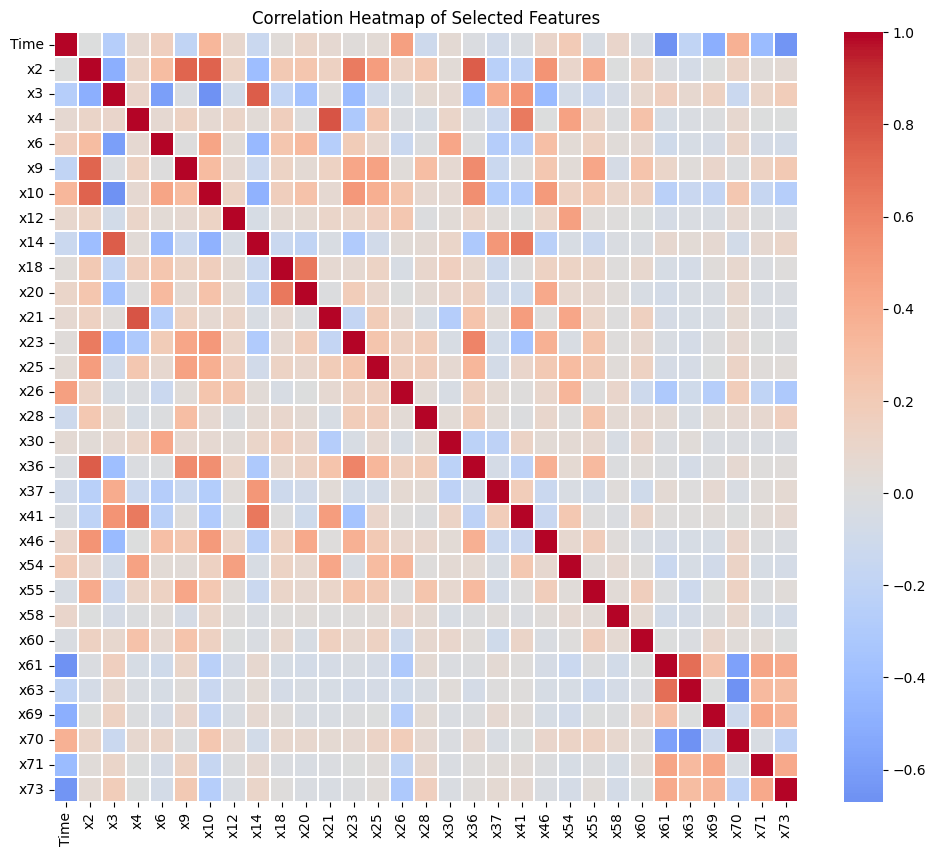

In [48]:
corr = df_reduced_2.corr()
plt.figure(figsize=(12,10))
sns.heatmap(
    df_reduced_2.drop('Financial Distress', axis=1).corr(),
    cmap="coolwarm",
    center=0,
    linewidths=0.3
)
plt.title("Correlation Heatmap of Selected Features")
plt.show()

**Summary:**

Given the high dimensionality of the dataset (86 numerical features), traditional visualization-based EDA (e.g., histograms and pairplots) was not practical. Instead, a **feature-centric and statistically driven EDA approach** was adopted.

- Removed **leakage features** that directly encode the target variable.  
- Checked **feature correlations**:  
  - Dropped highly correlated features to avoid redundancy.  
  - Kept the one most strongly correlated with the target.  
- Removed features with **very low correlation** (correlation < 0.05) with the target.   
- Final feature set consists of **31 important features** for modeling.

#### 4) **Modelling & Evaluation**

In [49]:
from sklearn.model_selection import train_test_split

X = df_reduced_2.drop("Financial Distress", axis=1)
y = df_reduced_2["Financial Distress"]

print("Final feature set:")
print(X.columns.tolist())
print(f"Number of features: {len(X.columns)}")


# First split: Train (70%) and Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

# Second split: Validation (15%) and Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)


Final feature set:
['Time', 'x2', 'x3', 'x4', 'x6', 'x9', 'x10', 'x12', 'x14', 'x18', 'x20', 'x21', 'x23', 'x25', 'x26', 'x28', 'x30', 'x36', 'x37', 'x41', 'x46', 'x54', 'x55', 'x58', 'x60', 'x61', 'x63', 'x69', 'x70', 'x71', 'x73']
Number of features: 31


**Model 1 - Baseline:** Logistic Regression

In [50]:
from sklearn.linear_model import LogisticRegression

baseline_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

baseline_model.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [51]:
from sklearn.metrics import classification_report, confusion_matrix, recall_score, f1_score

y_val_pred = baseline_model.predict(X_val)
recall = recall_score(y_val, y_val_pred, pos_label=1)
f1 = f1_score(y_val, y_val_pred, pos_label=1)

print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred, digits=4))

print("Confusion Matrix (Validation):")
print(confusion_matrix(y_val, y_val_pred))

print(f"\nMinority Class Recall: {recall:.4f}")
print(f"Minority Class F1-score: {f1:.4f}")


Validation Classification Report:
              precision    recall  f1-score   support

           0     0.9909    0.8208    0.8978       530
           1     0.1518    0.8095    0.2556        21

    accuracy                         0.8203       551
   macro avg     0.5713    0.8151    0.5767       551
weighted avg     0.9589    0.8203    0.8734       551

Confusion Matrix (Validation):
[[435  95]
 [  4  17]]

Minority Class Recall: 0.8095
Minority Class F1-score: 0.2556


**Model 2:** Random Forest Classifier

In [52]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=300, n_jobs=-1,
                       random_state=42)

In [53]:

y_val_pred_rf = rf_model.predict(X_val)
rf_recall = recall_score(y_val, y_val_pred_rf, pos_label=1)
rf_f1 = f1_score(y_val, y_val_pred_rf, pos_label=1)

print("Random Forest – Validation Report")
print(classification_report(y_val, y_val_pred_rf, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_rf))

print(f"\nRF Minority Recall: {rf_recall:.4f}")
print(f"RF Minority F1: {rf_f1:.4f}")


Random Forest – Validation Report
              precision    recall  f1-score   support

           0     0.9740    0.9906    0.9822       530
           1     0.5833    0.3333    0.4242        21

    accuracy                         0.9655       551
   macro avg     0.7787    0.6619    0.7032       551
weighted avg     0.9591    0.9655    0.9610       551

Confusion Matrix:
[[525   5]
 [ 14   7]]

RF Minority Recall: 0.3333
RF Minority F1: 0.4242


**Model 3:** XGB Classifier

In [54]:
from xgboost import XGBClassifier

neg, pos = y_train.value_counts()
scale_pos_weight = neg / pos

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    random_state=42
)

xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [55]:
y_val_pred_xgb = xgb_model.predict(X_val)
xgb_recall = recall_score(y_val, y_val_pred_xgb, pos_label=1)
xgb_f1 = f1_score(y_val, y_val_pred_xgb, pos_label=1)

print("XGBoost – Validation Report")
print(classification_report(y_val, y_val_pred_xgb, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_xgb))

print(f"\nXGB Minority Recall: {xgb_recall:.4f}")
print(f"XGB Minority F1: {xgb_f1:.4f}")


XGBoost – Validation Report
              precision    recall  f1-score   support

           0     0.9770    0.9604    0.9686       530
           1     0.3000    0.4286    0.3529        21

    accuracy                         0.9401       551
   macro avg     0.6385    0.6945    0.6608       551
weighted avg     0.9512    0.9401    0.9451       551

Confusion Matrix:
[[509  21]
 [ 12   9]]

XGB Minority Recall: 0.4286
XGB Minority F1: 0.3529


In [56]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Minority Recall": [0.8095, rf_recall, xgb_recall],
    "Minority F1": [0.2556, rf_f1, xgb_f1]
})

results

,Model,Minority Recall,Minority F1
0,Logistic Regression,0.809500,0.255600
1,Random Forest,0.333333,0.424242
2,XGBoost,0.428571,0.352941


**Summary:**
- A Logistic Regression model with class weighting was used as an imbalance-aware baseline.
- Random Forest: Strong baseline upgrade from logistic; handles imbalance + non‑linearity.
- XGBoost: Usually #1 in recent studies for financial distress; excellent with imbalance via scale_pos_weight.

XGBoost edges out as your winner with better minority recall (0.43 vs 0.33) despite lower F1, while Random Forest sacrifices too much recall for precision.


#### 5) **Best Model:** Hyperparameter & Threshold Tuning

In [57]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

# Define XGBoost with basic parameters
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    scale_pos_weight=(y_train==0).sum() / (y_train==1).sum(),
    random_state=42
)

# Hyperparameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5, 7]
}

# Use F1 for minority class as scoring
f1_scorer = make_scorer(f1_score, pos_label=1)

# RandomizedSearchCV
rand_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,            # can increase to 100 if time allows
    scoring=f1_scorer,
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

rand_search.fit(X_train, y_train)

# Best XGBoost model
best_xgb = rand_search.best_estimator_
Best_Parameters = rand_search.best_params_
print("Best Parameters:", Best_Parameters)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.7, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:44:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [58]:
# Verify the model expects these features
print("Model expects these features:")
print(best_xgb.get_booster().feature_names)

Model expects these features:
['Time', 'x2', 'x3', 'x4', 'x6', 'x9', 'x10', 'x12', 'x14', 'x18', 'x20', 'x21', 'x23', 'x25', 'x26', 'x28', 'x30', 'x36', 'x37', 'x41', 'x46', 'x54', 'x55', 'x58', 'x60', 'x61', 'x63', 'x69', 'x70', 'x71', 'x73']


   threshold    recall        f1
0       0.05  0.857143  0.236842
1       0.10  0.809524  0.261538
2       0.15  0.809524  0.288136
3       0.20  0.761905  0.299065
4       0.25  0.761905  0.323232
5       0.30  0.761905  0.340426
6       0.35  0.714286  0.337079
7       0.40  0.666667  0.337349
8       0.45  0.619048  0.342105
9       0.50  0.571429  0.342857


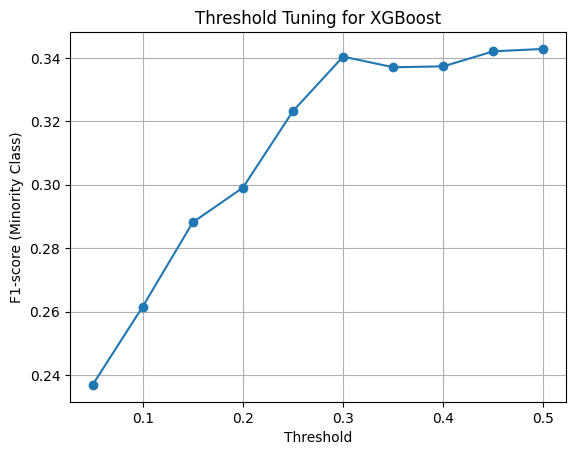

Optimal Threshold: 0.45
Recall at this threshold: 0.6190476190476191
F1-score at this threshold: 0.34210526315789475
Validation Classification Report at Optimal Threshold:
              precision    recall  f1-score   support

           0     0.9839    0.9208    0.9513       530
           1     0.2364    0.6190    0.3421        21

    accuracy                         0.9093       551
   macro avg     0.6101    0.7699    0.6467       551
weighted avg     0.9554    0.9093    0.9281       551

Confusion Matrix:
[[488  42]
 [  8  13]]


In [59]:
# Predict probabilities on validation set
y_val_probs = best_xgb.predict_proba(X_val)[:, 1]

thresholds = np.arange(0.05, 0.51, 0.05)
results = []

for t in thresholds:
    y_pred_t = (y_val_probs >= t).astype(int)
    results.append({
        "threshold": t,
        "recall": recall_score(y_val, y_pred_t, pos_label=1),
        "f1": f1_score(y_val, y_pred_t, pos_label=1)
    })

results_df = pd.DataFrame(results)
print(results_df)

# Plot F1 vs Threshold
plt.plot(results_df['threshold'], results_df['f1'], marker='o')
plt.xlabel("Threshold")
plt.ylabel("F1-score (Minority Class)")
plt.title("Threshold Tuning for XGBoost")
plt.grid(True)
plt.show()

# Pick threshold that gives target recall >= 0.6
optimal = results_df[results_df['recall'] >= 0.6].sort_values('f1', ascending=False).iloc[0]
optimal_threshold = optimal['threshold']
print(f"Optimal Threshold: {optimal_threshold}")
print(f"Recall at this threshold: {optimal['recall']}")
print(f"F1-score at this threshold: {optimal['f1']}")

# Apply optimal threshold
y_val_pred_opt = (y_val_probs >= optimal_threshold).astype(int)
report_dict = classification_report(y_val, y_val_pred_opt, digits=4, output_dict=True)
print("Validation Classification Report at Optimal Threshold:")
print(classification_report(y_val, y_val_pred_opt, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_opt))


**Summary:** Business Perspective on Model Performance

From a business standpoint, correctly identifying financially distressed companies is far more critical than mistakenly flagging healthy ones.
- A **false negative — predicting a distressed company as healthy** — can result in serious consequences, such as unpaid employees, missed bill payments, or financial collapse going unnoticed.
- In contrast, a **false positive — predicting a healthy company as distressed** — mainly leads to additional reviews or administrative checks, which are relatively low-cost.

Therefore, the model is optimized for high recall on the distressed class, even if it means accepting more false positives.

#### 6) **Deployment**
Finalizing XGBoost model with tuned hyperparameters and threshold for production-ready use.

In [60]:
import joblib

# selected features
final_features = best_xgb.get_booster().feature_names
joblib.dump(final_features, "final_features.pkl")

# Save the XGBoost model and threshold
joblib.dump(best_xgb, "xgb_final_model.pkl")
joblib.dump(0.45, "optimal_threshold.pkl")


['optimal_threshold.pkl']

#### 7) **ML Flow**
Experiment Tracking & Model Registry

In [2]:
!pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.3/788.3 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 7.9 MB/s eta 0:00:00


In [61]:
import mlflow

**Experiment Tracking**

In [63]:
mlflow.set_experiment("Exp-test1")
mlflow.set_tracking_uri("http://localhost:5000")

with mlflow.start_run(): # Log params, metrics, models
    mlflow.log_params(Best_Parameters)
    mlflow.log_metrics({
        'accuracy': report_dict['accuracy'],
        'recall_class_0': report_dict['0']['recall'],
        'recall_class_1': report_dict['1']['recall'],
        'f1_score_macro': report_dict['macro avg']['f1-score']
        })
    mlflow.sklearn.log_model(best_xgb, "Best XGBoost Model")

KeyboardInterrupt: 

**Model Registry**

In [35]:
mlflow.register_model(
    model_uri="models:/m-529c9f7fe809463bbb7536956624dea4",
    name="xgboost1"
)

Enter Run ID:s


2026/01/27 10:16:09 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/01/27 10:16:09 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/01/27 10:16:09 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/01/27 10:16:09 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/01/27 10:16:09 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/01/27 10:16:09 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/01/27 10:16:10 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/27 10:16:10 INFO mlflow.store.db.utils: Updating database tables
2026/01/27 10:16:10 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/27 10:16:10 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/27 10:16:10 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/27 10:16:10 INFO alembic.runtime

MlflowException: Run with id=s not found

**Load the model**

In [ ]:
loaded_model = mlflow.sklearn.load_model(model_uri = "models:/m-529c9f7fe809463bbb7536956624dea4")
y_pred = loaded_model.predict(X_test)
y_pred[:10]

**Transition from Dev enviroment to Production**

In [ ]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
for rm in client.search_registered_models():
    print(rm.name)


In [ ]:
client.transition_model_version_stage(
    name="xgboost1",
    version=1,
    stage="Production",
    archive_existing_versions=True
)